In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
data_path = "../data/20210429_B16_SiV/"

cavity_files = ["bb2_raw-counts_x_14_23_44.txt", "bb2_raw-counts_14_23_44.txt"]
siv_files = [["sweeper_fwd_avg_15_19_21.txt", "sweeper_fwd_scans_15_19_19.txt"],
             ["sweeper_fwd_avg_15_25_01.txt", "sweeper_fwd_scans_15_25_00.txt"],
             ["sweeper_fwd_avg_15_49_44.txt", "sweeper_fwd_scans_15_49_43.txt"]]

# Plot data

## Plot Cavity Data

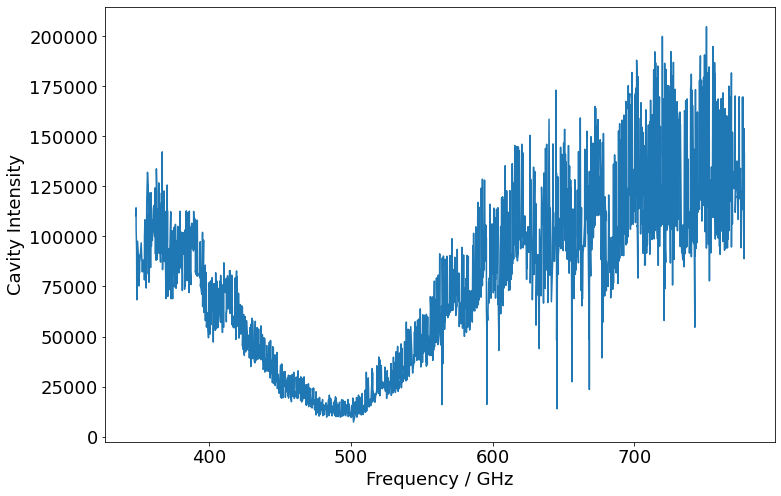

In [3]:
plt.figure(figsize=[12, 8])

cavity_freqs = np.loadtxt(data_path + cavity_files[0])
cavity_intensity = np.loadtxt(data_path + cavity_files[1])

cavity_freqs = 1000 * (cavity_freqs - 406) # Re-center, convert to GHz
plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")

# Sort by frequency values
cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot SiV Data

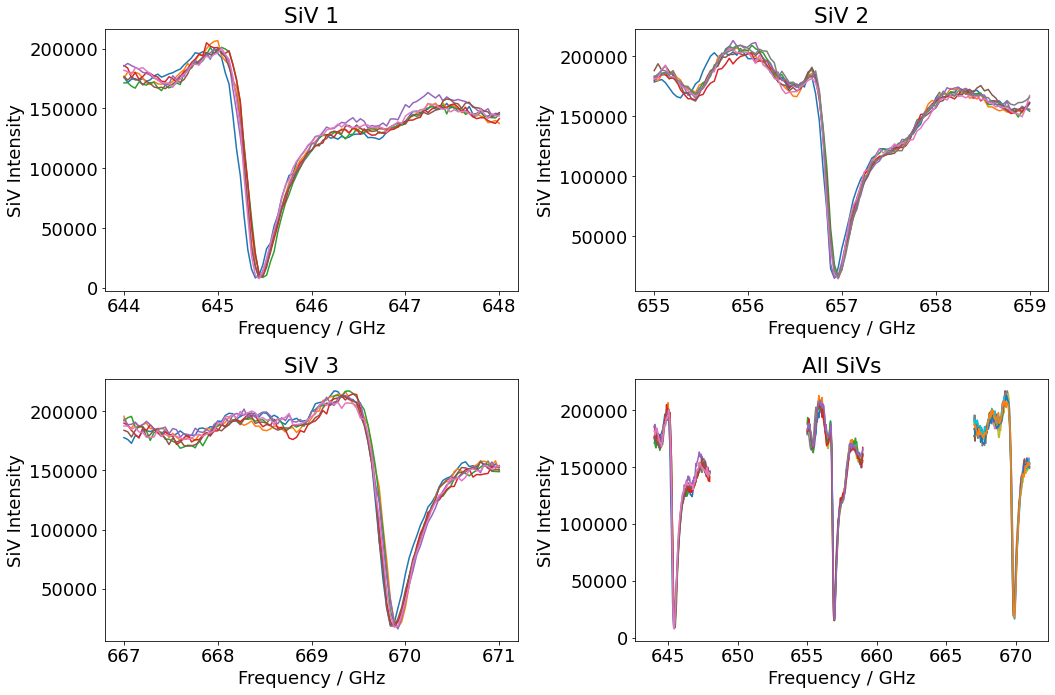

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[15, 10])

for idx, siv_files_tuple in enumerate(siv_files):
    # Extract freq from the avg scan file
    siv_freqs, _ = np.loadtxt(data_path + siv_files_tuple[0])
    siv_freqs = 1000 * (siv_freqs - 406)

    # Extract data from the SiV scan file
    siv_data = np.loadtxt(data_path + siv_files_tuple[1])

    for siv_series in siv_data:
        ax[idx//2, idx%2].plot(siv_freqs, siv_series)
        ax[1, 1].plot(siv_freqs, siv_series)

for idx in range(4):
    axes = ax[idx//2, idx%2]
    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
    if idx != 3: 
        axes.set_title(f"SiV {idx+1}")
    else:
        axes.set_title(f"All SiVs")
        
fig.tight_layout()

# --------------------
# Fit Cavity Spectrum

### Unfiltered

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 2812
    # variables        = 4
    chi-square         = 1.0229e+12
    reduced chi-square = 3.6429e+08
    Akaike info crit   = 55438.2473
    Bayesian info crit = 55462.0139
[[Variables]]
    w_c:    491.884766 +/- 0.66372895 (0.13%) (init = 500)
    k_in:   61.5146898 +/- 1.60010275 (2.60%) (init = 30)
    k_tot:  95.4975829 +/- 1.88706562 (1.98%) (init = 50)
    A:      143260.264 +/- 1215.42162 (0.85%) (init = 200000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.963
    C(k_tot, A)    =  0.823
    C(k_in, A)     =  0.712
    C(w_c, A)      =  0.118


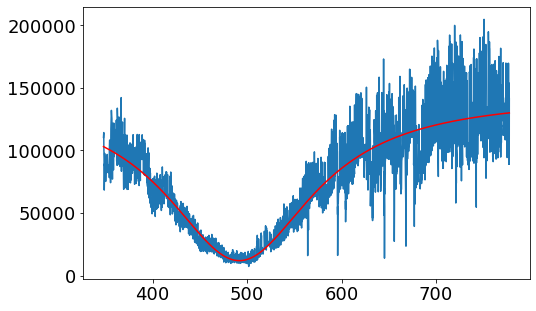

In [5]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=500, min=400, max=600),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=200000, min=00000, max=500000),
    Parameter('B', value=0, vary=False),
)

cavity_results = cavity_ref_model.fit(cavity_intensity, params, w=cavity_freqs)
lmfit.report_fit(cavity_results)

plt.plot(cavity_freqs, cavity_intensity)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity / cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:38<00:00, 60.85it/s]


Autocorrelation times: [45.2171 52.4641 51.8509 50.4163 64.8326]
Max 50 x Autocorrelation times: 3241.6299543127884

Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_c:        491.882225 +/- 0.66741131 (0.14%) (init = 491.8848)
    k_in:       61.5426967 +/- 1.59565077 (2.59%) (init = 61.51469)
    k_tot:      95.5569167 +/- 1.88148389 (1.97%) (init = 95.49758)
    A:          143304.330 +/- 1219.62658 (0.85%) (init = 143260.3)
    B:          0 (fixed)
    __lnsigma:  9.85675561 +/- 0.01335679 (0.14%) (init = 10.81978)
[[Correlations]] (unreported correlations are < 0.400)
    C(k_in, k_tot) =  0.963
    C(k_tot, A)    =  0.824
    C(k_in, A)     =  0.712

Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  w_c      491.93954   491.88223       0.66741
  k_in      61.63322    61.54270       1.59565
  k_tot     95.59965    95.5569

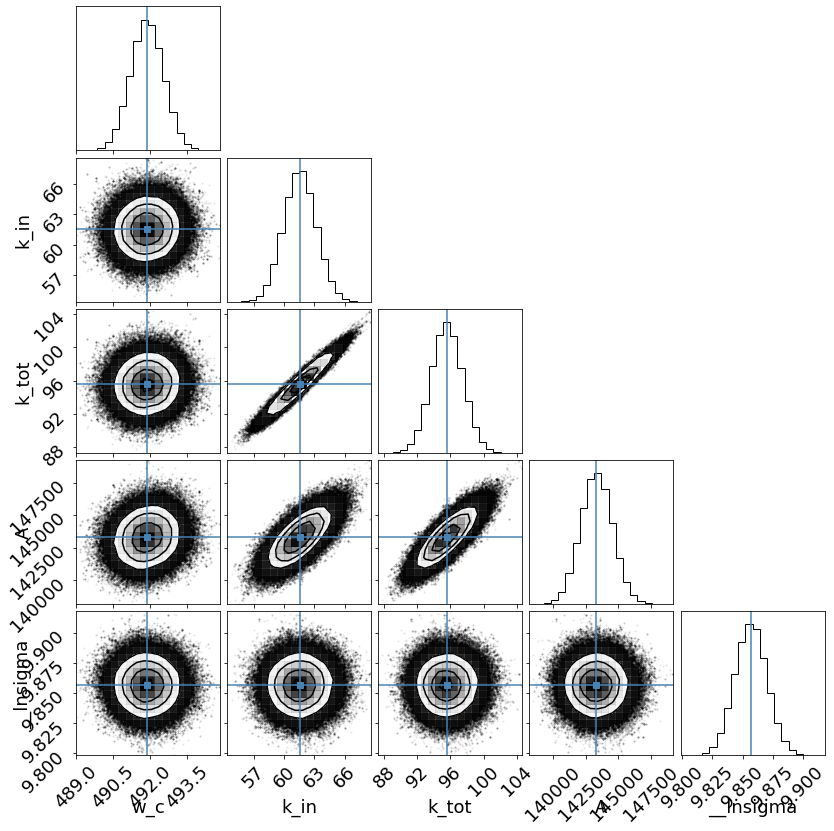

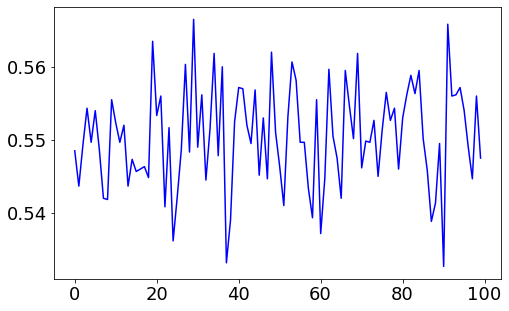

In [6]:
# Compute the correlations and error in the fits using MCMC
# data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
emcee_results, emcee_mle_params = mcmc(cavity_freqs, cavity_intensity, cavity_ref_model, cavity_results, 
                                       data_noise=[50000, 5000, 200000], input_params={"steps": 6000})

### Filtered Cavity

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 1858
    # variables        = 4
    chi-square         = 5.7789e+11
    reduced chi-square = 3.1170e+08
    Akaike info crit   = 36341.9172
    Bayesian info crit = 36364.0262
[[Variables]]
    w_c:    490.712967 +/- 0.83920235 (0.17%) (init = 500)
    k_in:   59.5950271 +/- 1.82858459 (3.07%) (init = 30)
    k_tot:  93.1236126 +/- 2.28970586 (2.46%) (init = 50)
    A:      143740.070 +/- 1286.06946 (0.89%) (init = 200000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.972
    C(k_tot, A)    =  0.806
    C(k_in, A)     =  0.726
    C(w_c, k_tot)  =  0.483
    C(w_c, k_in)   =  0.430
    C(w_c, A)      =  0.350


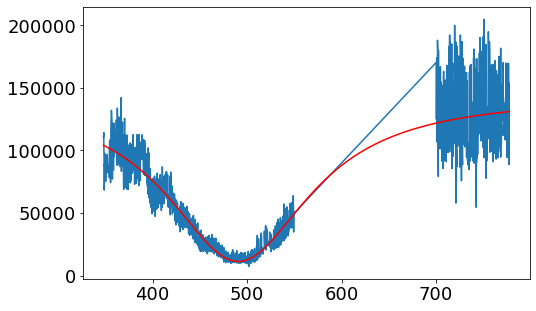

In [7]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

# Range of frequencies to filter out to remove SiV peaks
filter_range = [(550, 700)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=500, min=400, max=600),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=200000, min=100000, max=500000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs_filtered)

# Fit SiV Spectrum

## Fit SiV 1

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 101
    # variables        = 4
    chi-square         = 2.3803e+09
    reduced chi-square = 24539655.9
    Akaike info crit   = 1722.51454
    Bayesian info crit = 1732.97502
[[Variables]]
    w_up:      645.144751 +/- 0.00656495 (0.00%) (init = 645.5)
    g_up:      6.67530852 +/- 0.06589938 (0.99%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       491.93 (fixed)
    k_in:      49.6184661 +/- 1.61833432 (3.26%) (init = 80)
    k_tot:     95.64 (fixed)
    A:         219164.064 +/- 777.885236 (0.35%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.857
    C(w_up, k_in) =  0.646
    C(g_up, k_in) = -0.397
    C(g_up, A)    =  0.240
    C(w_up, A)    = -0.163


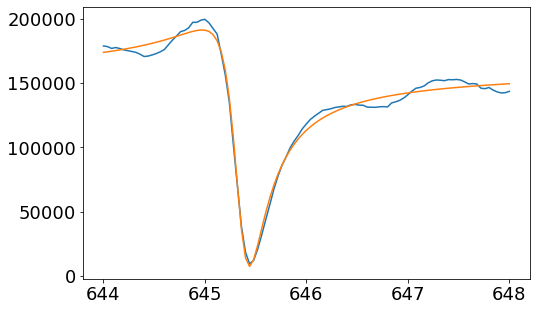

In [8]:
siv_index = 1
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv1_freqs, siv1_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv1_freqs = 1000 * (siv1_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=491.93, vary=False),
    Parameter('k_in', value=80, min=40, max=100),
    Parameter('k_tot', value=95.64, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv1_results = single_siv_ref_model.fit(siv1_mean, params, w=siv1_freqs)
lmfit.report_fit(siv1_results)

plt.plot(siv1_freqs, siv1_mean)
plt.plot(siv1_freqs, single_siv_ref_model.eval(siv1_results.params, w=siv1_freqs))

## Fit SiV 2

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 101
    # variables        = 4
    chi-square         = 1.1311e+10
    reduced chi-square = 1.1660e+08
    Akaike info crit   = 1879.92310
    Bayesian info crit = 1890.38358
[[Variables]]
    w_up:      656.719738 +/- 0.01114977 (0.00%) (init = 656.9)
    g_up:      6.24726977 +/- 0.13141872 (2.10%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       491.93 (fixed)
    k_in:      56.7283223 +/- 3.56914348 (6.29%) (init = 50)
    k_tot:     95.64 (fixed)
    A:         226615.022 +/- 2040.50244 (0.90%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.737
    C(k_in, A)    = -0.651
    C(w_up, k_in) =  0.469
    C(w_up, A)    = -0.436
    C(g_up, A)    =  0.127


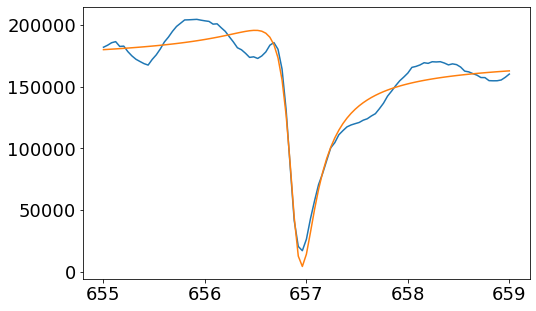

In [9]:
siv_index = 2
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv2_freqs, siv2_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv2_freqs = 1000 * (siv2_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=656.9, min=656, max=657.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=491.93, vary=False),
    Parameter('k_in', value=50, min=0, max=100),
    Parameter('k_tot', value=95.64, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv2_results = single_siv_ref_model.fit(siv2_mean, params, w=siv2_freqs)
lmfit.report_fit(siv2_results)

plt.plot(siv2_freqs, siv2_mean)
plt.plot(siv2_freqs, single_siv_ref_model.eval(siv2_results.params, w=siv2_freqs))

## Fit SiV 3

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 101
    # variables        = 4
    chi-square         = 2.7501e+09
    reduced chi-square = 28351087.7
    Akaike info crit   = 1737.09641
    Bayesian info crit = 1747.55689
[[Variables]]
    w_up:      669.559767 +/- 0.00860303 (0.00%) (init = 669.8)
    g_up:      7.39283453 +/- 0.09775867 (1.32%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       491.93 (fixed)
    k_in:      45.0878201 +/- 1.53918513 (3.41%) (init = 80)
    k_tot:     95.64 (fixed)
    A:         226368.801 +/- 851.948156 (0.38%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.939
    C(w_up, k_in) =  0.776
    C(g_up, k_in) = -0.722
    C(k_in, A)    =  0.559
    C(w_up, A)    =  0.408
    C(g_up, A)    = -0.384


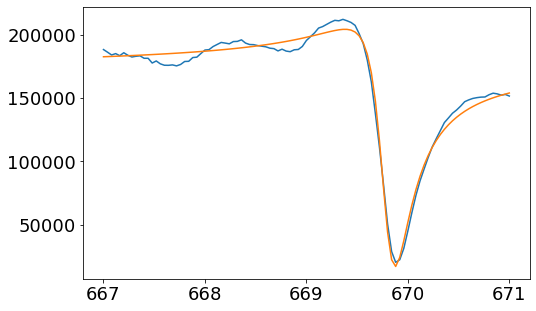

In [10]:
siv_index = 3
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv3_freqs, siv3_mean = np.loadtxt(data_path + siv_files_tuple[0])
siv3_freqs = 1000 * (siv3_freqs - 406)

params = Parameters()
params.add_many(
    Parameter('w_up', value=669.8, min=669, max=670.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=491.93, vary=False),
    Parameter('k_in', value=80, min=40, max=100),
    Parameter('k_tot', value=95.64, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv3_results = single_siv_ref_model.fit(siv3_mean, params, w=siv3_freqs)
lmfit.report_fit(siv3_results)

plt.plot(siv3_freqs, siv3_mean)
plt.plot(siv3_freqs, single_siv_ref_model.eval(siv3_results.params, w=siv3_freqs))

# Measure SiV contrast

In [11]:
# Average estimate of parameters from SiV 
w_c_fit = emcee_mle_params["w_c"].value
k_tot_fit = emcee_mle_params["k_tot"].value
A_fit = np.mean([siv1_results.params["A"].value, siv2_results.params["A"].value, siv3_results.params["A"].value])
k_in_fit = np.mean([siv1_results.params["k_in"].value, siv2_results.params["k_in"].value, siv3_results.params["k_in"].value])
g_up_fit = np.mean([siv1_results.params["g_up"].value, siv2_results.params["g_up"].value, siv3_results.params["g_up"].value])

Text(0, 0.5, 'SiV Peak Contrast')

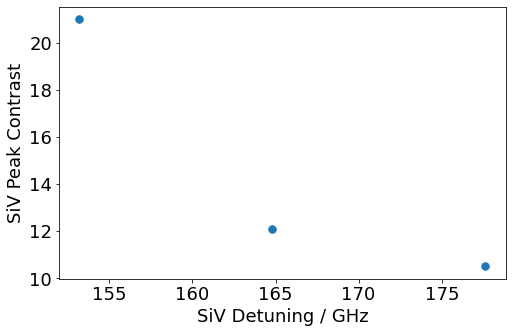

In [12]:
# Array of SiV resonance freqs
siv_res_freqs = np.array([siv1_results.params["w_up"].value, siv2_results.params["w_up"].value, siv3_results.params["w_up"].value])
# Array of SiV detunings
siv_res_detunings = siv_res_freqs - w_c_fit 

siv_min_dips = []
siv_contrasts = []
for siv_files_tuple in siv_files:
    # Get the mean from the avg scan
    _, siv_mean = np.loadtxt(data_path + siv_files_tuple[0])
    siv_min_dips.append(min(siv_mean))
    siv_contrasts.append(max(siv_mean) / min(siv_mean))

plt.plot(siv_res_detunings, siv_contrasts, '.', ms=15)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Peak Contrast")

### Compare against simulated diffused SiV 

In [13]:
# Diffusion stdev list
diffusion_stdev_list = np.geomspace(5e-3, 10, 8)
# List of SiV detunings to iterate over
detuning_freqs = np.linspace(-250, 250, 1000)

# Cavity parameters taken from cavity and SiV estimates
# w_up will be varied by diffused_siv_peaks()
c = Cavity({"w_c" : 0, "k_in" : k_in_fit, "k_tot" : k_tot_fit}, 
           {"w_up" : 0, "g_up" : g_up_fit, "gamma_up" : 0.05})

# Stores the simulated diffused SiV min/max values
diffused_siv_min_list = []
diffused_siv_max_list = []

# Compute the siv min/max for clean and diffused!
for diffusion_stdev in diffusion_stdev_list:
    siv_min, siv_max, diffused_siv_min, diffused_siv_max = diffused_siv_peaks(c, detuning_freqs, diffusion_stdev, plot=False)
    diffused_siv_min_list.append(diffused_siv_min)
    diffused_siv_max_list.append(diffused_siv_max)
    
diffused_siv_min_list = np.array(diffused_siv_min_list)
diffused_siv_max_list = np.array(diffused_siv_max_list)

The current value of diffusion of 0.005 requires 30000 freq steps.
The current value of diffusion of 0.014809681479725867 requires 10128 freq steps.


(0.0, 25.0)

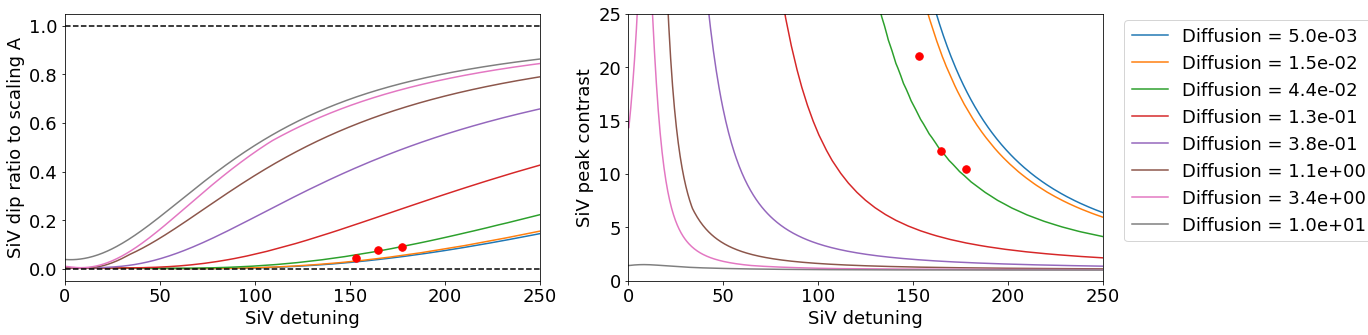

In [15]:
# Plot simulated diffused SiV contrasts and dip ratio
# NOTE: Here we instead compare against 1, which is the unperturbed cavity value (i.e. is the scaling constant A)
fig, ax = plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, diffused_siv_min_list, diffused_siv_max_list, cavity_min=1)

# Overlay experimental values. 
# NOTE: Here we scale the SiV to the unperturbed value, i.e. the scaling constant A
ax[0].plot(siv_res_detunings, siv_min_dips / A_fit, 'r.', ms=15)
ax[0].set_ylabel("SiV dip ratio to scaling A")

ax[1].plot(siv_res_detunings, siv_contrasts, 'r.', ms=15) 
ax[1].set_ylim(0, 25)

(0.0, 25.0)

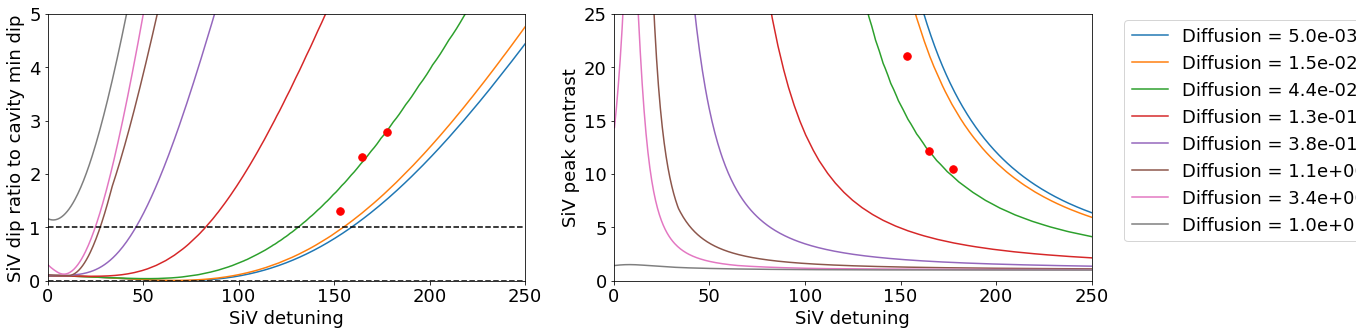

In [16]:
# Plot simulated diffused SiV contrasts and dip ratio
# Multiply the theoretically computed diffused_siv by the fitted A for the SiVs
# Compare against the real cavity mi
fig, ax = plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, A_fit * diffused_siv_min_list, A_fit * diffused_siv_max_list, cavity_min=min(cavity_intensity))

# Overlay experimental values. Ratio of real SiV min and cavity min.
ax[0].plot(siv_res_detunings, siv_min_dips / min(cavity_intensity), 'r.', ms=15)
ax[0].set_ylabel("SiV dip ratio to cavity min dip")
ax[0].set_ylim(0, 5)

ax[1].plot(siv_res_detunings, siv_contrasts, 'r.', ms=15) 
ax[1].set_ylim(0, 25)

# Redo with individual SiV Scans

## Fit SiV 1

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 101
    # variables        = 4
    chi-square         = 3.0532e+09
    reduced chi-square = 31476670.3
    Akaike info crit   = 1747.65911
    Bayesian info crit = 1758.11960
[[Variables]]
    w_up:      645.073407 +/- 0.00777619 (0.00%) (init = 645.5)
    g_up:      6.96325545 +/- 0.07603253 (1.09%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       491.93 (fixed)
    k_in:      49.2931929 +/- 1.85467768 (3.76%) (init = 80)
    k_tot:     95.64 (fixed)
    A:         218142.419 +/- 897.761931 (0.41%) (init = 200000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.864
    C(w_up, k_in) =  0.644
    C(g_up, k_in) = -0.402
    C(g_up, A)    =  0.240
    C(w_up, A)    = -0.151
    C(k_in, A)    =  0.106


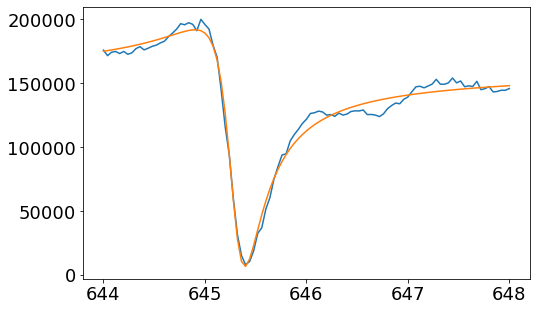

In [21]:
siv_index = 1
siv_files_tuple = siv_files[siv_index - 1] 

# Extract freq from the avg scan file
siv1_freqs, _ = np.loadtxt(data_path + siv_files_tuple[0])
siv1_freqs = 1000 * (siv1_freqs - 406)
siv1_data = np.loadtxt(data_path + siv_files_tuple[1])[0]

params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=491.93, vary=False),
    Parameter('k_in', value=80, min=40, max=100),
    Parameter('k_tot', value=95.64, vary=False),
    Parameter('A', value=200000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

siv1_results = single_siv_ref_model.fit(siv1_data, params, w=siv1_freqs)
lmfit.report_fit(siv1_results)

plt.plot(siv1_freqs, siv1_data)
plt.plot(siv1_freqs, single_siv_ref_model.eval(siv1_results.params, w=siv1_freqs))

## Estimate contrast / dip with individual sweeps

### Taking data from ALL series

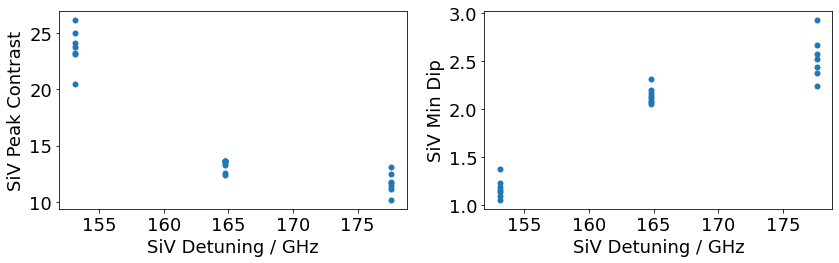

In [51]:
siv_min_dips = []
siv_contrasts = []

for idx, siv_files_tuple in enumerate(siv_files):
    detuning = siv_res_detunings[idx]
    data_series = np.loadtxt(data_path + siv_files_tuple[1])
    min_dip = np.inf
    max_contrast = 0
    
    for series in range(data_series.shape[0]):
        siv_data = np.loadtxt(data_path + siv_files_tuple[1])[series]
        siv_min_dips.append((detuning, min(siv_data) / min(cavity_intensity)))
        siv_contrasts.append((detuning, max(siv_data) / min(siv_data)))
            
plt.figure(figsize=[12, 4])
plt.subplot(121)
plt.plot(*zip(*siv_contrasts), '.', ms=10)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Peak Contrast")

plt.subplot(122)
plt.plot(*(zip(*siv_min_dips)), '.', ms=10)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Min Dip")
plt.tight_layout()

### Taking only the best data from each SiV

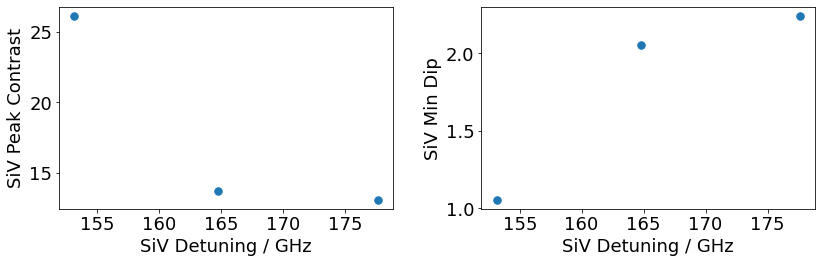

In [40]:
siv_min_dips = []
siv_contrasts = []

for siv_files_tuple in siv_files:
    data_series = np.loadtxt(data_path + siv_files_tuple[1])
    min_dip = np.inf
    max_contrast = 0
    
    for series in range(data_series.shape[0]):
        siv_data = np.loadtxt(data_path + siv_files_tuple[1])[series]
        min_dip = min(min_dip, min(siv_data))
        max_contrast = max(max_contrast, max(siv_data) / min(siv_data))
            
    siv_min_dips.append(min_dip / min(cavity_intensity))
    siv_contrasts.append(max_contrast)

plt.figure(figsize=[12, 4])
plt.subplot(121)
plt.plot(siv_res_detunings, siv_contrasts, '.', ms=15)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Peak Contrast")

plt.subplot(122)
plt.plot(siv_res_detunings, siv_min_dips, '.', ms=15)    
plt.xlabel("SiV Detuning / GHz")
plt.ylabel("SiV Min Dip")
plt.tight_layout()

### Compare against simulated diffused SiV 

In [29]:
# Diffusion stdev list
diffusion_stdev_list = np.geomspace(5e-3, 10, 8)
# List of SiV detunings to iterate over
detuning_freqs = np.linspace(-250, 250, 1000)

# Cavity parameters taken from cavity and SiV estimates
# w_up will be varied by diffused_siv_peaks()
c = Cavity({"w_c" : 0, "k_in" : k_in_fit, "k_tot" : k_tot_fit}, 
           {"w_up" : 0, "g_up" : g_up_fit, "gamma_up" : 0.05})

# Stores the simulated diffused SiV min/max values
diffused_siv_min_list = []
diffused_siv_max_list = []

# Compute the siv min/max for clean and diffused!
for diffusion_stdev in diffusion_stdev_list:
    siv_min, siv_max, diffused_siv_min, diffused_siv_max = diffused_siv_peaks(c, detuning_freqs, diffusion_stdev, plot=False)
    diffused_siv_min_list.append(diffused_siv_min)
    diffused_siv_max_list.append(diffused_siv_max)
    
diffused_siv_min_list = np.array(diffused_siv_min_list)
diffused_siv_max_list = np.array(diffused_siv_max_list)

The current value of diffusion of 0.005 requires 30000 freq steps.
The current value of diffusion of 0.014809681479725867 requires 10128 freq steps.


(0.0, 30.0)

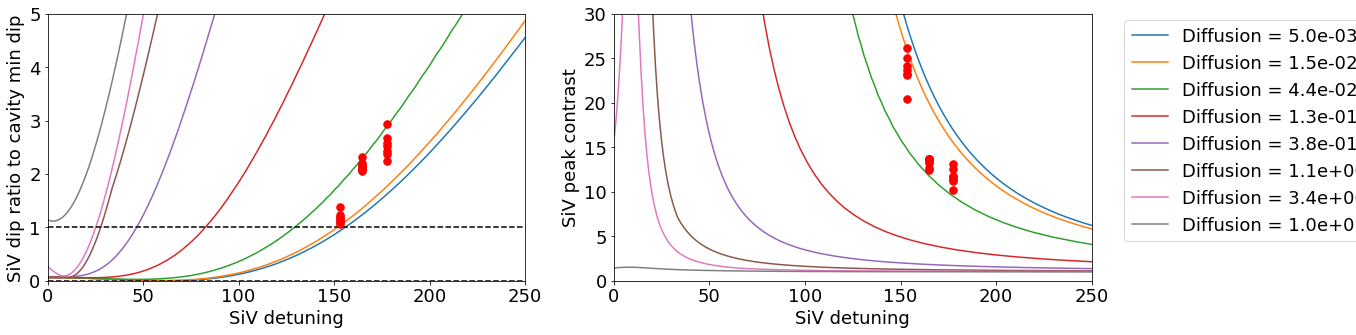

In [54]:
# Plot simulated diffused SiV contrasts and dip ratio
# Multiply the theoretically computed diffused_siv by the fitted A for the SiVs
# Compare against the real cavity mi
fig, ax = plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, A_fit * diffused_siv_min_list, A_fit * diffused_siv_max_list, cavity_min=min(cavity_intensity))

# Overlay experimental values. Ratio of real SiV min and cavity min.
ax[0].plot(*zip(*siv_min_dips), 'r.', ms=15)
ax[0].set_ylabel("SiV dip ratio to cavity min dip")
ax[0].set_ylim(0, 5)

ax[1].plot(*zip(*siv_contrasts), 'r.', ms=15) 
ax[1].set_ylim(0, 30)